In [1]:
import random, edlib, os
import multiprocessing as mp
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyBioInfo.IO.File import BamFile
from pyBioInfo.Utils import BundleBuilder

# Random UMI edit distance

In [10]:
def load_random_umi_edit_distance(path):
    random.seed(0)
    reads = []
    with BamFile(path) as f:
        for bundle in BundleBuilder(f, keep=True):
            reads.append(random.sample(bundle.data, 1)[0])   
    umis = [read.segment.get_tag("UM") for read in reads]
    eds = []
    for i in range(len(umis) - 1):
        for j in range(i + 1, len(umis)):
            umi1, umi2 = umis[i], umis[j]
            if len(umi1) > len(umi2):
                umi1, umi2 = umi2, umi1
            eds.append(edlib.align(umi1, umi2, mode="HW")["editDistance"])
    return Counter(eds)

paths = [
    "../../1_NanoNASCseq/results/mapping/processed/20220719_K562R1/20220719_K562R1.C01.bam",
    "../../1_NanoNASCseq/results/mapping/processed/20220719_K562R1/20220719_K562R1.C02.bam",
    "../../1_NanoNASCseq/results/mapping/processed/20220719_K562R1/20220719_K562R1.C03.bam",
    "../../1_NanoNASCseq/results/mapping/processed/20220719_K562R1/20220719_K562R1.C04.bam",
    "../../1_NanoNASCseq/results/mapping/processed/20220719_K562R1/20220719_K562R1.C05.bam",
    "../../1_NanoNASCseq/results/mapping/processed/20220719_K562R1/20220719_K562R1.C06.bam",
    "../../1_NanoNASCseq/results/mapping/processed/20220719_K562R1/20220719_K562R1.C07.bam",
    "../../1_NanoNASCseq/results/mapping/processed/20220719_K562R1/20220719_K562R1.C08.bam",
    "../../1_NanoNASCseq/results/mapping/processed/20220719_K562R1/20220719_K562R1.C09.bam",
    "../../1_NanoNASCseq/results/mapping/processed/20220719_K562R1/20220719_K562R1.C10.bam"]

array = []
pool = mp.Pool(10)
for path in paths:
    array.append(pool.apply_async(load_random_umi_edit_distance, (path,)))
pool.close()
pool.join()
array = [r.get() for r in array]

Cells: 10


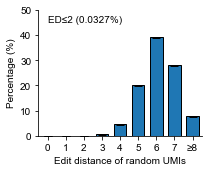

In [11]:
print("Cells:", len(array))
ed_max = 8
rows = []
for counter in array:
    row = np.zeros(ed_max + 1)
    for ed, count in counter.items():
        row[min(ed, len(row) - 1)] += count
    rows.append(row)
d = pd.DataFrame(rows)
columns = list(map(str, d.columns))
columns[-1] = "≥%s" % columns[-1]
d.columns = columns
d1 = d.divide(d.sum(axis=1), axis=0) * 100

ys = d1.mean(axis=0)
yerr = d1.std(axis=0)
xs = np.arange(len(ys))
ticks = d1.columns
plt.figure(figsize=(3, 2.5))
plt.bar(xs, ys, yerr=yerr, edgecolor="black", width=0.7, color="C0", error_kw={"capsize": 4})
if False:
    plt.plot([-0.3, 2.3], [10, 10], color="red", lw=2)
    plt.text(1, 11, "%.4f%%" % sum(ys[:3]), ha="center", va="bottom", color="red")
else:
    plt.text(0, 45, "ED≤2 (%.4f%%)" % sum(ys[:3]))
plt.xticks(xs, ticks)
plt.xlabel("Edit distance of random UMIs")
plt.ylabel("Percentage (%)")
plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
plt.ylim(0, 50)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("figures/random_cluster_umi_ed.pdf", dpi=300)

# Number of UMI

In [2]:
d = pd.read_excel("../../1_NanoNASCseq/data/NanoNASCseq_summary_selected.xls")
d1 = d[(d["Strain"] == "K562") & (d["s4U"] == 0) & (d["Time"] == 3) & (d["ActD"].isna()) & (d["UMIs"] >= 0)]
d2 = d[(d["Strain"] == "K562") & (d["s4U"] == 50) & (d["Time"] == 3) & (d["ActD"].isna()) & (d["UMIs"] >= 0)]
d3 = d[(d["Strain"] == "mESC") & (d["s4U"] == 0) & (d["Time"] == 3) & (d["ActD"].isna()) & (d["UMIs"] >= 0)]
d4 = d[(d["Strain"] == "mESC") & (d["s4U"] == 400) & (d["Time"] == 3) & (d["ActD"].isna()) & (d["UMIs"] >= 0)]
print(len(d1), len(d2), len(d3), len(d4), sep="\t")

199	189	64	123


In [3]:
params = [
    ["K562", 0, 3, d1],
    ["K562", 50, 3, d2],
    ["mESC", 0, 3, d3],
    ["mESC", 400, 3, d4],
]

data = dict()
for strain, s4u, time, d in params:
    for cell in d["Cell"]:
        path = "../../1_NanoNASCseq/results/mapping/marked_duplicate/%s/%s.tsv" % (cell.split(".")[0], cell)
        data[cell] = pd.read_csv(path, sep="\t", header=0)

In [4]:
rows = []
x = 0
for min_reads in [1, 2]:
    for d in [d1, d2, d3, d4]:
        vs = []
        for cell in d["Cell"]:
            tmp = data[cell]
            tmp = tmp[tmp["DownSampleSize"] >= min_reads]
            rows.append([x, len(tmp)])
        x += 1
d = pd.DataFrame(rows, columns=["Type", "UMIs"])

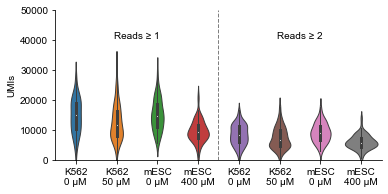

In [5]:
xs = np.arange(8)

plt.figure(figsize=(5.5, 2.8))
ret = sns.violinplot(data=d, x="Type", y="UMIs", scale="area", width=0.8, linewidth=1)
plt.xlim(-0.5, 7.5)
plt.ylim(0, 50000)
plt.axvline(3.5, lw=1, color="grey", ls="--")
plt.text(1.5, 40000, "Reads ≥ 1", ha="center", va="bottom")
plt.text(5.5, 40000, "Reads ≥ 2", ha="center", va="bottom")
plt.xlabel(None)
plt.xticks(xs, [
    "K562\n0 μM", "K562\n50 μM", 
    "mESC\n0 μM", "mESC\n400 μM", 
    "K562\n0 μM", "K562\n50 μM", 
    "mESC\n0 μM", "mESC\n400 μM"])
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("figures/umi_counts.pdf", dpi=300)

# Reads per UMI

In [7]:
d = pd.read_excel("../../1_NanoNASCseq/data/NanoNASCseq_summary_selected.xls")
d1 = d[(d["Strain"] == "K562") & (d["s4U"] == 0) & (d["Time"] == 3) & (d["ActD"].isna()) & (d["UMIs"] >= 5000)]
d2 = d[(d["Strain"] == "K562") & (d["s4U"] == 50) & (d["Time"] == 3) & (d["ActD"].isna()) & (d["UMIs"] >= 5000)]
d3 = d[(d["Strain"] == "mESC") & (d["s4U"] == 0) & (d["Time"] == 3) & (d["ActD"].isna()) & (d["UMIs"] >= 5000)]
d4 = d[(d["Strain"] == "mESC") & (d["s4U"] == 400) & (d["Time"] == 3) & (d["ActD"].isna()) & (d["UMIs"] >= 5000)]
print(len(d1), len(d2), len(d3), len(d4), sep="\t")

190	179	64	112


In [8]:
params = [
    ["K562", 0, 3, d1],
    ["K562", 50, 3, d2],
    ["mESC", 0, 3, d3],
    ["mESC", 400, 3, d4],
]

data = dict()
for strain, s4u, time, d in params:
    for cell in d["Cell"]:
        path = "../../1_NanoNASCseq/results/mapping/marked_duplicate/%s/%s.tsv" % (cell.split(".")[0], cell)
        data[cell] = pd.read_csv(path, sep="\t", header=0)

--------------------------------------------------------------------------------
K562	0	3	190
Mean:
1     42.185409
2     12.148747
3      6.931047
4      4.683124
5      3.463382
6      2.719988
7      2.197538
8      1.840697
9      1.556936
10    22.273133
dtype: float64
Std:
1     2.382221
2     1.162826
3     0.661388
4     0.423552
5     0.308127
6     0.224460
7     0.207013
8     0.174663
9     0.162137
10    3.912366
dtype: float64
--------------------------------------------------------------------------------
K562	50	3	179
Mean:
1     41.026367
2     11.915657
3      6.881948
4      4.634802
5      3.453430
6      2.738302
7      2.220339
8      1.846990
9      1.575403
10    23.706762
dtype: float64
Std:
1     2.595555
2     1.381043
3     0.731899
4     0.498883
5     0.339488
6     0.267108
7     0.209662
8     0.180566
9     0.168240
10    4.046435
dtype: float64
--------------------------------------------------------------------------------
mESC	0	3	64
Mean:
1     38.9

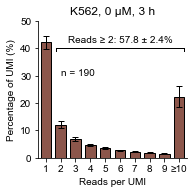

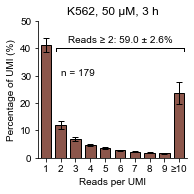

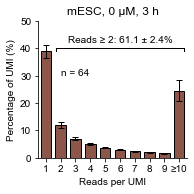

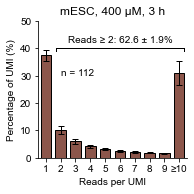

In [9]:
for strain, s4u, time, d in params:
    print("-" * 80)
    print(strain, s4u, time, len(d), sep="\t")
    
    rows = []
    for cell in d["Cell"]:
        counter = Counter(data[cell]["AllSize"])
        row = [counter[i] for i in range(10)]
        row.append(sum(counter.values()) - sum(row))
        rows.append(row)
    m = pd.DataFrame(rows)
    m.columns = np.arange(11)
    m = m[m.columns[1:]]
    m = m[m.sum(axis=1) >= 5000] # UMIs >= 5000
    m = m.divide(m.sum(axis=1), axis=0) * 100
    
    ys = m.mean(axis=0)
    yerr = m.std(axis=0)
    print("Mean:")
    print(ys)
    print("Std:")
    print(yerr)
    
    xs = m.columns
    xticks = list(xs)
    xticks[-1] = "≥10"
    plt.figure(figsize=(2.8, 2.8))
    plt.title("%s, %d μM, %d h" % (strain, s4u, time))
    plt.bar(xs, ys, yerr=yerr, color="C5", edgecolor="black", width=0.7,
            error_kw={"capsize": 3, "capthick": 1, "lw": 1})
    plt.text(2, 30, "n = %d" % len(d))
    if True:
        vs = m[m.columns[m.columns >= 2]].sum(axis=1)
        y = 40
        lw = 1
        plt.text(6, y + 2, "Reads ≥ 2: %.1f ± %.1f%%" % (np.mean(vs), np.std(vs)), ha="center")
        plt.plot([2 - 0.3, 10 + 0.3], [y, y], lw=lw, color="black")
        plt.plot([2 - 0.3, 2 - 0.3], [y, y - 1], lw=lw, color="black")
        plt.plot([10 + 0.3, 10 + 0.3], [y, y - 1], lw=lw, color="black")
        
    
    plt.xlim(0.5, 10.5)
    plt.ylim(0, 50)
    plt.xticks(xs, xticks)
    plt.xlabel("Reads per UMI")
    plt.ylabel("Percentage of UMI (%)")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.tight_layout()
    plt.savefig("figures/reads_per_umi.%s.%duM_%dh.pdf" % (strain, s4u, time), dpi=300)
    
    # break

# Select reads for IGV visualization

Gene: GAPDH

In [47]:
import pysam
bamfile = "../../1_NanoNASCseq/results/mapping/marked_duplicate/20220729_K562R1/20220729_K562R1.C02.bam"
outfile = "outputs/20220729_K562R1.C02.GAPDH2.forIGV.bam"
with pysam.AlignmentFile(bamfile) as f, pysam.AlignmentFile(outfile, "wb", f) as fw:
    data = defaultdict(list)
    for s in f.fetch("chr12", 6534298, 6538480):
        data[s.get_tag("UM")].append(s)
    segments = []
    random.seed(0)
    for k, v in data.items():
        if len(v) > 3:
            segments.extend(random.sample(v, 3))
        else:
            segments.extend(v)
    for s in sorted(segments, key=lambda s: s.reference_start):
        fw.write(s)
! samtools index {outfile}